In [1]:
%matplotlib inline

In [2]:
import numpy as np
import fitsio as ft
import healpy as hp

import sys
sys.path.insert(0, '/home/mehdi/github/sysnetdev')
sys.path.insert(0, '/home/mehdi/github/LSSutils')

from lssutils.utils import hpix2radec
from lssutils.stats.nnbar import MeanDensity
from lssutils.dataviz import setup_color
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

from glob import glob

In [12]:
import corner

In [3]:
def hist(ngal, frac, syst, bins):
    ng,_,_ = binned_statistic(syst, ngal, statistic='sum', bins=bins)
    nr,_,_ = binned_statistic(syst, frac, statistic='sum', bins=bins)
    ns,_,_ = binned_statistic(syst, syst, statistic='mean', bins=bins)
    
    #nstd,_,_ = binned_statistic(syst, ngal/frac, statistic=np.std, bins=bins)
    #nmodes,_,_ = binned_statistic(syst, np.ones(syst.size), statistic='count', bins=bins)
    norm = ng.sum()/nr.sum()
    mean = ng/(nr*norm)
    #err = nstd/np.sqrt(nmodes)
    return (ns, mean)

def makehp(hpix, value, nside):
    res_ = np.zeros(12*nside*nside)
    res_[hpix] = value
    return res_

def model(x, theta):
    """ Linear model """
    return x.dot(theta[1:]) + theta[0]


def makehp_wlin(xs, theta, hpix):
    p = [8.58112598, 3.4692057 ]
    w_s = model(xs, theta)
    w_ = (w_s*p[1])+p[0]
    
    w_w = w_ / w_.mean()
    w_w = w_w.clip(0.5, 2.0)    
    
    return makehp(hpix, w_w, 1024)

In [4]:
df = ft.read('/home/mehdi/data/tanveer/dr8_elg_ccd_1024.fits')
print(df.dtype.names)

ngal = makehp(df['hpix'], df['label'], 1024)
syst = makehp(df['hpix'], df['features'][:, 1], 1024)
mask = makehp(df['hpix'], 1.0, 1024) > 0
frac = makehp(df['hpix'], df['fracgood'], 1024)

print(np.percentile(ngal[mask], [2.5, 97.5]))

('label', 'features', 'hpix', 'fracgood')
[ 3. 16.]


In [5]:
bins = np.linspace(*np.percentile(syst[mask], [1, 99]), num=9)
bins

array([19.91269067, 20.03898559, 20.16528052, 20.29157544, 20.41787036,
       20.54416528, 20.6704602 , 20.79675512, 20.92305004])

In [6]:
r = {}

#nbar = MeanDensity(ngal, frac, mask, syst, bins=bins, binning='simple', nbins=8)
#nbar.run()
r['DR8 ELGs'] = hist(ngal[mask], frac[mask], syst[mask], bins)

In [7]:
df_p = '/home/mehdi/data/tanveer/dr8_elg_ccd_1024_sub.fits'
df_ = ft.read(df_p)

# normalize the features
xmean = np.mean(df_['features'], axis=0)
xstd = np.std(df_['features'], axis=0)
del df_

xs = (df['features'] - xmean) / xstd

In [8]:
chains = np.load('/home/mehdi/github/linear/chains.npy', allow_pickle=True)
chains.shape

(1000, 400, 22)

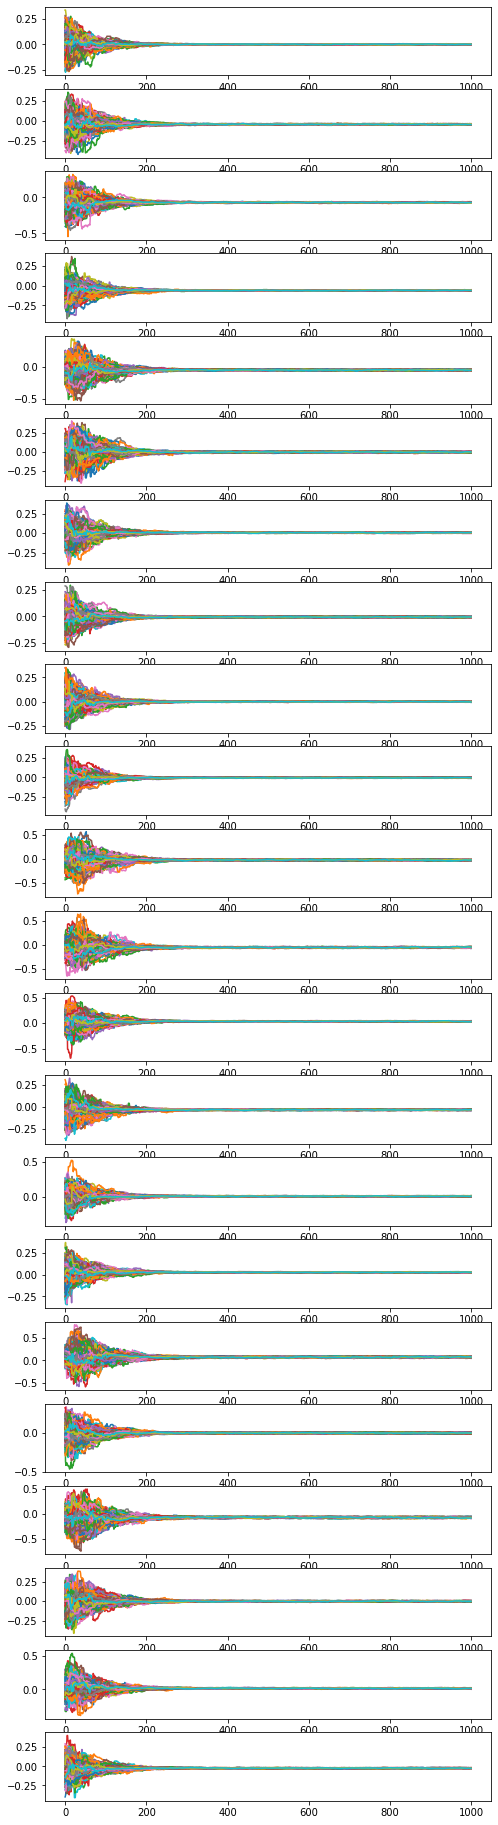

In [9]:
fg, ax = plt.subplots(nrows=22, figsize=(8, 33))
ax = ax.flatten()

for i in range(22):
    for j in range(400):
        ax[i].plot(chains[:, j, i])

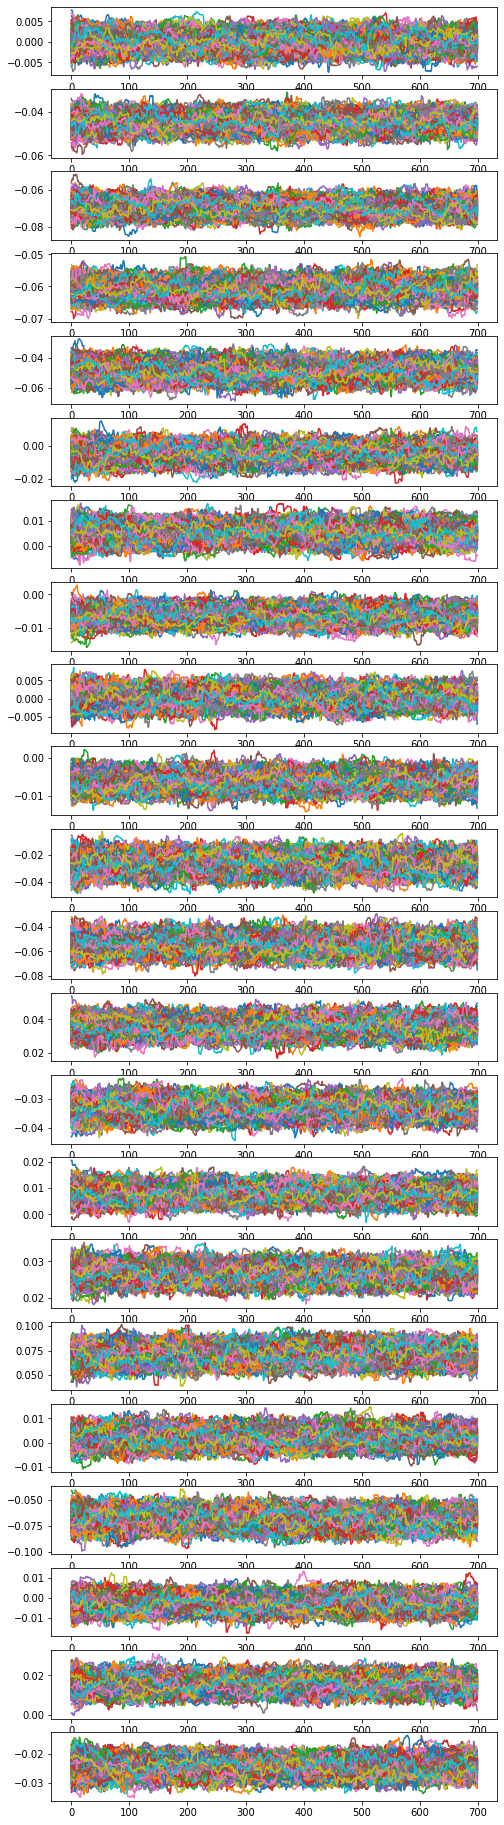

In [10]:
fg, ax = plt.subplots(nrows=22, figsize=(8, 33))
ax = ax.flatten()

for i in range(22):
    for j in range(400):
        ax[i].plot(chains[300:, j, i])

In [14]:
chains_red = chains[300:, :, :]
chains_red = chains_red.reshape(700*400, 22)

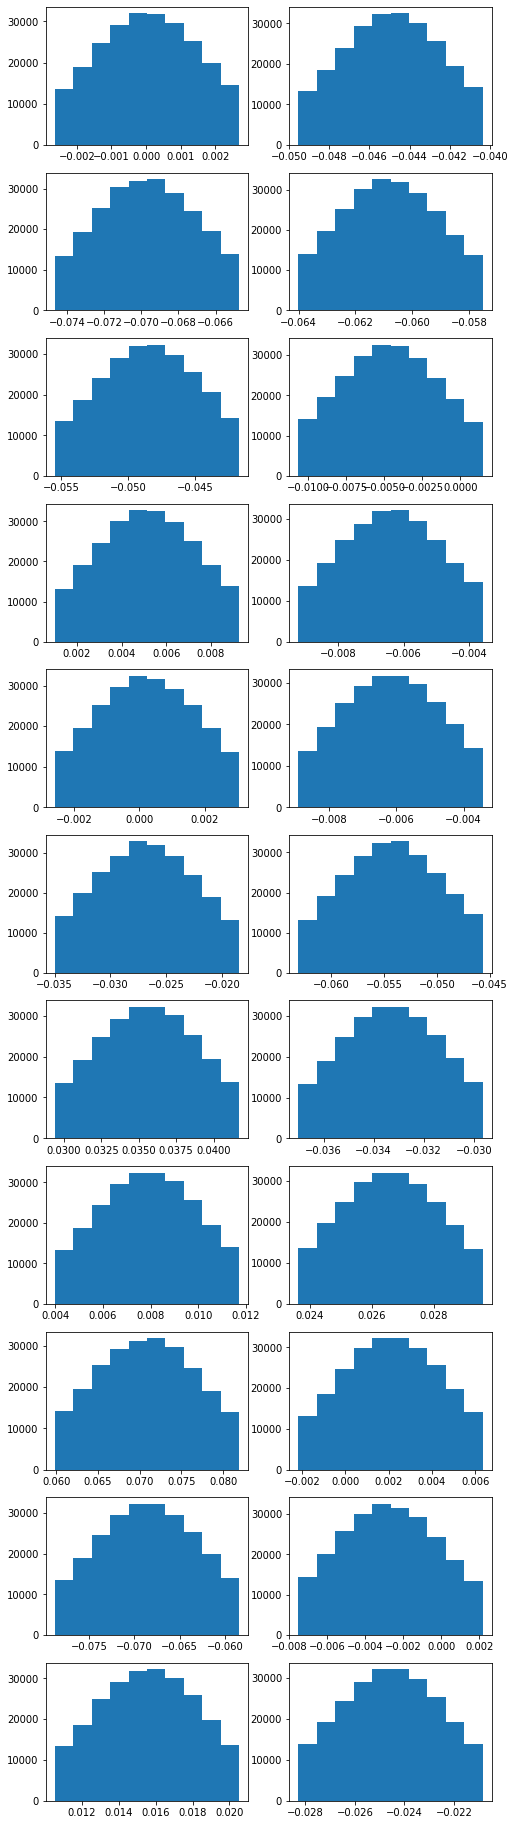

In [16]:
fg, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 33))
ax = ax.flatten()

for i in range(22):
    min_, max_ = np.percentile(chains[:, :, i], [15., 85.])
    ax[i].hist(chains_red[:, :, i].flatten(), range=(min_, max_))

In [36]:
stats = np.load('/home/mehdi/github/linear/stats_xy.npz', allow_pickle=True)
stats.files

['x', 'y']

In [37]:
stats['y']

array([8.58112598, 3.4692057 ])

In [38]:
ix = np.random.choice(np.arange(chains_red.shape[0]), size=100, replace=False)

for i in ix:
    whp = makehp_wlin(xs, chains_red[i, :], df['hpix'])
    r['mock_%d'%i] = hist(whp[mask], frac[mask], syst[mask], bins)
    print('.', end='')

....................................................................................................

Text(0, 0.5, 'Mean Density')

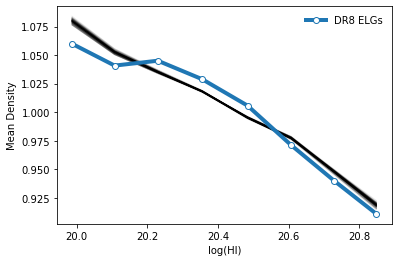

In [39]:
for name, val in r.items():
    #if np.any(val[1] < 0.9):
    #    print(name)
    #    continue
    if name == 'DR8 ELGs':
        plt.plot(val[0], val[1], marker='o', mfc='w', ls='-', label=name, lw=4)
    else:
        plt.plot(val[0], val[1], lw=1, color='k', ls='-', zorder=-1, alpha=0.1)
        
plt.legend(frameon=False)
plt.xlabel('log(HI)')
plt.ylabel('Mean Density')
# plt.savefig('/home/mehdi/data/tanveer/elg_mse_snapshots/ngal_loghi.png', 
#             dpi=300, bbox_inches='tight')

In [ ]:
# TODO: 
# 1. Find out what subset of these correlate with the Sag. stream
# 2. Cross correlation between the mitigated and imaging C_ell^{g,s} and (C_s,g)^2 / (C_g,g * C_s,s)

In [22]:
columns = np.array(['C', 'ebv', 'loghi', 'nstar',
    'depth_r_total', 'depth_g_total', 'depth_z_total',
     'fwhm_r_mean', 'fwhm_g_mean', 'fwhm_z_mean',
    'airmass_r_mean', 'airmass_g_mean', 'airmass_z_mean',
    'ccdskymag_r_mean', 'ccdskymag_g_mean', 'ccdskymag_z_mean',
     'exptime_r_total', 'exptime_g_total', 'exptime_z_total',
     'mjd_r_min', 'mjd_g_min', 'mjd_z_min']) # 
len(columns)

22

In [19]:
for i, col in enumerate(columns):
    print(i, col)

0 C
1 ebv
2 loghi
3 nstar
4 depth_r_total
5 depth_g_total
6 depth_z_total
7 fwhm_r_mean
8 fwhm_g_mean
9 fwhm_z_mean
10 airmass_r_mean
11 airmass_g_mean
12 airmass_z_mean
13 ccdskymag_r_mean
14 ccdskymag_g_mean
15 ccdskymag_z_mean
16 exptime_r_total
17 exptime_g_total
18 exptime_z_total
19 mjd_r_min
20 mjd_g_min
21 mjd_z_min


In [23]:
ix = [0, 1, # C, EBV 
      4, 7,
      10, 13, 16, 19]    #dep-r, fwhm-r


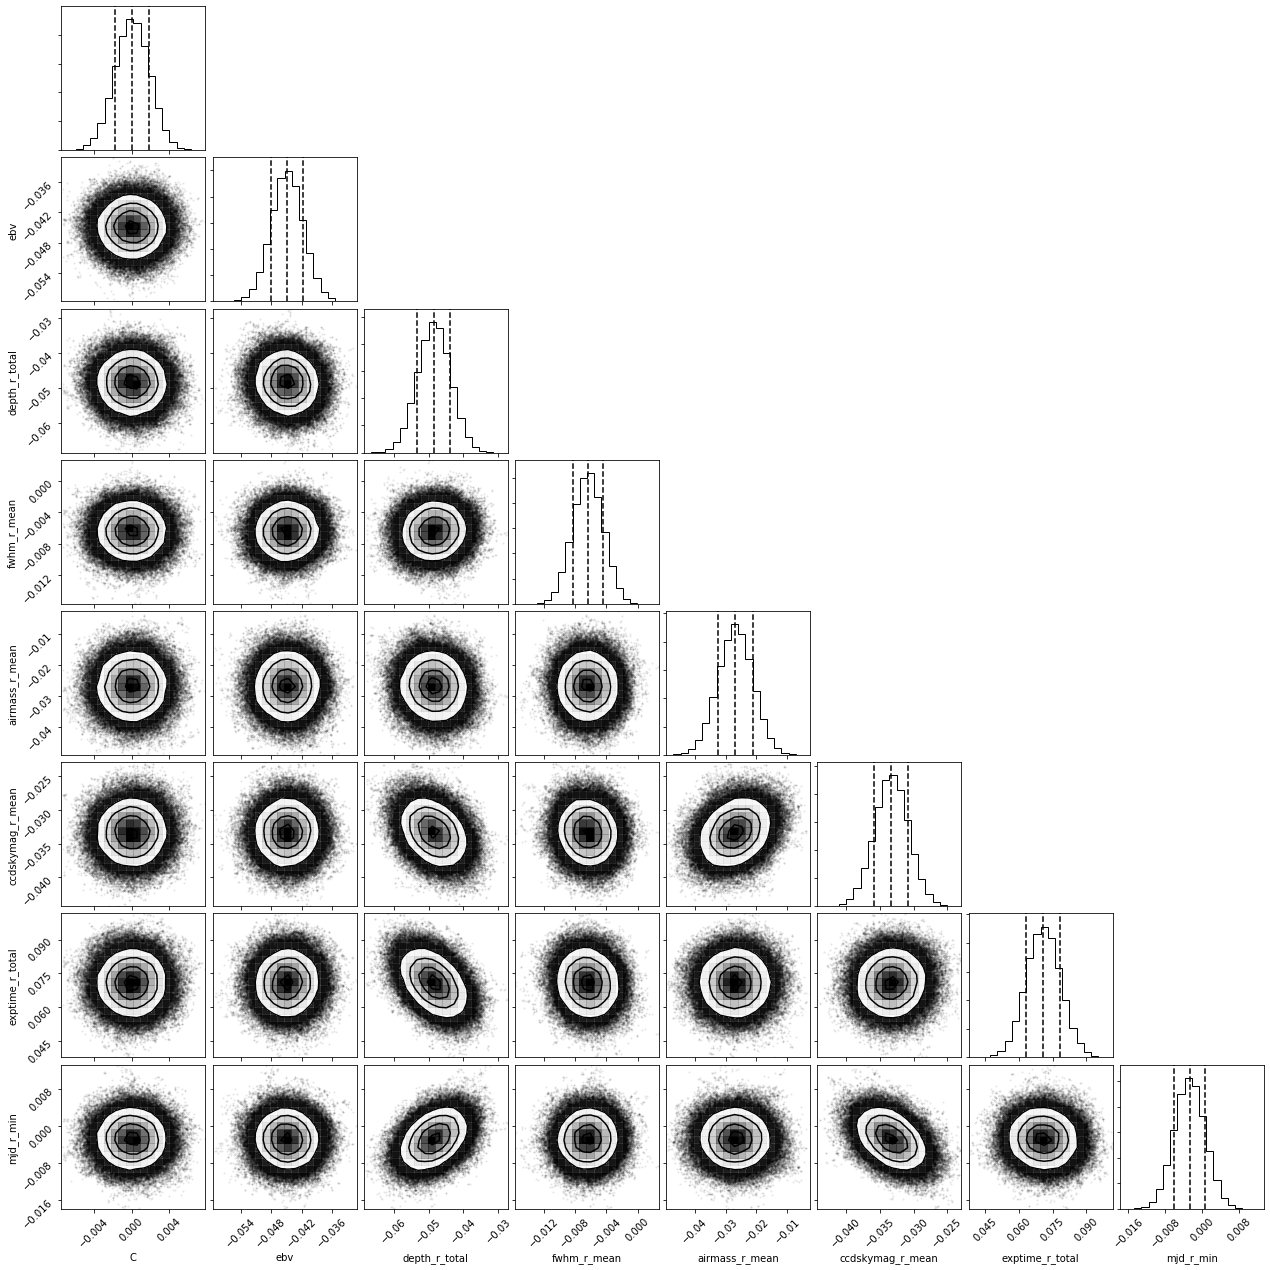

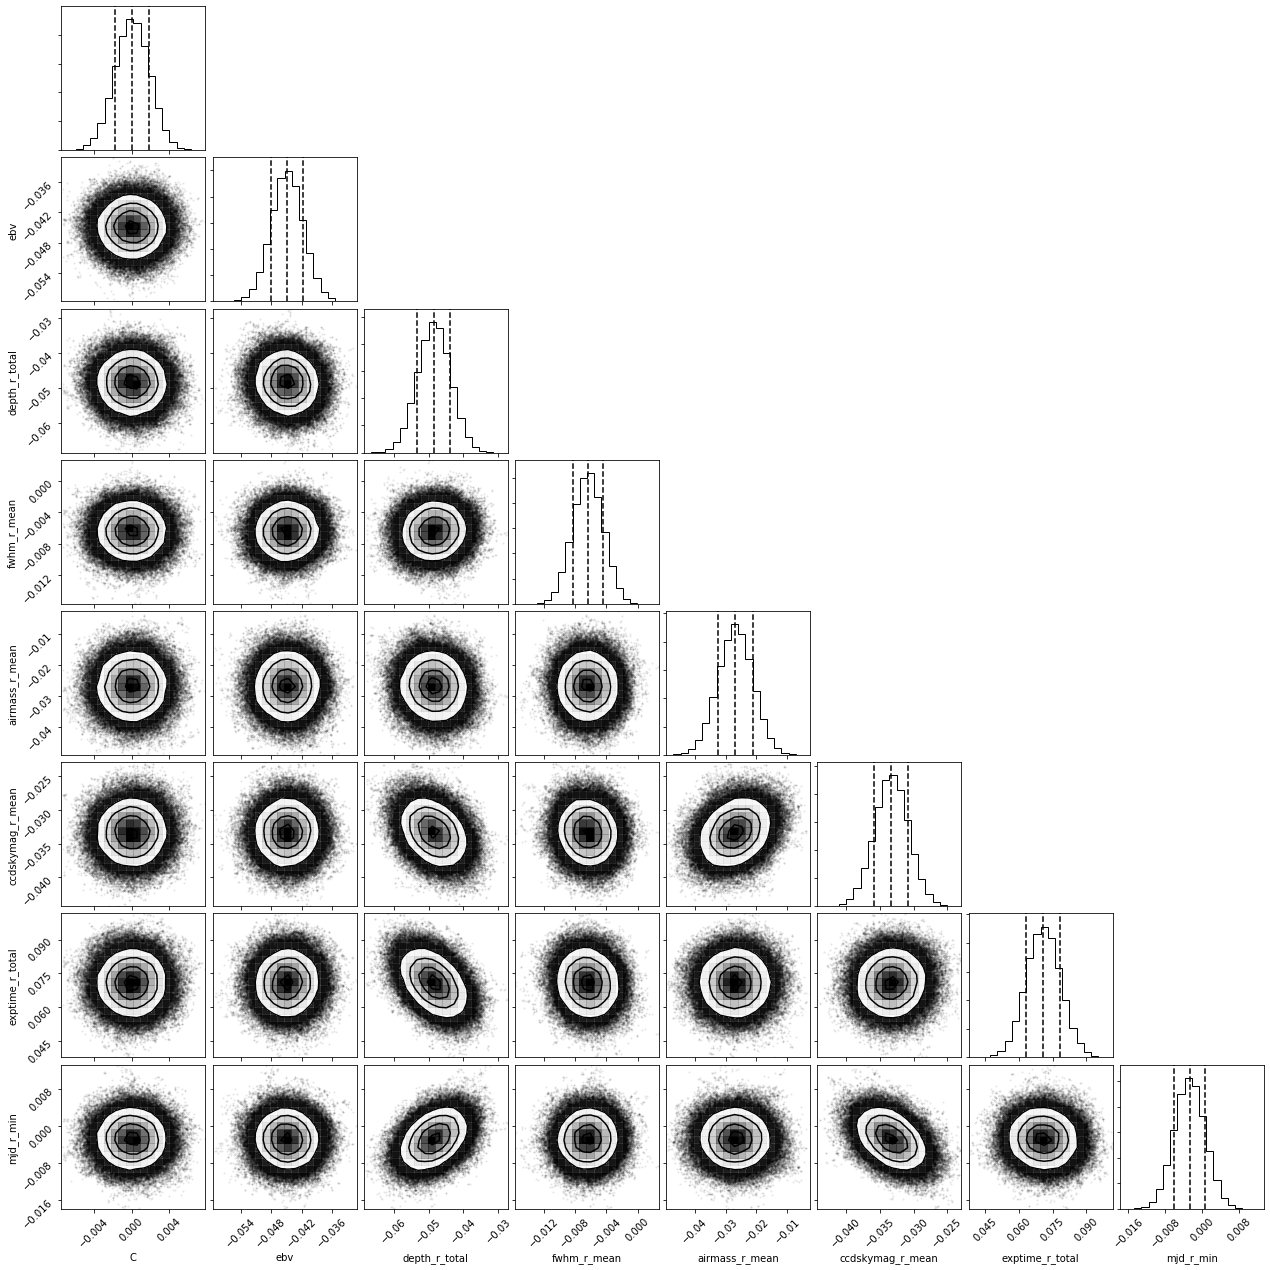

In [24]:
corner.corner(chains_red[:, ix], quantiles=np.array([0.16, 0.5, 0.84]), labels=columns[ix])

In [25]:
# diagnostics on the chains
# 1. Corner plot to see the correlation between the different parameters
# 2. Rank plot
# 3. Find the best fit, and covariance and use those to initialize the starting points
# (make sure these are inside the priors)
# or 4. scale the label (y)